In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read the MArchive data
df = pd.read_csv('../../dataset.csv')

In [3]:
# Drop the unnecessary columns
df.drop(['File name', 'header'], axis = 1, inplace = True)

In [4]:
# Taking only the malicious samples
df = df[df['Class'] == 'Malicious'] 

In [5]:
# Drop the null values in malicious samples
df.dropna(axis = 0, inplace = True)

In [6]:
# Check for duplicates
duplicate_rows = df[df.duplicated()]

In [7]:
print(f'Number of duplicates in the dataset is {len(duplicate_rows)}')

Number of duplicates in the dataset is 181


In [8]:
# Drop the dupllicate values
df = df.drop_duplicates()

In [9]:
# Re-Check for duplicates
duplicate_rows = df[df.duplicated()]

In [10]:
print(f'Number of duplicates in the dataset is {len(duplicate_rows)}')

Number of duplicates in the dataset is 0


In [11]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [12]:
encoder = LabelEncoder()

In [13]:
# Encode the 'text' and 'Class' column
df['text'] = encoder.fit_transform(df['text']) 
df['Class'] = df['Class'].apply(lambda x: 1 if 'malicious' in str(x).lower() else 0)

In [14]:
df['Class'].unique()

array([1], dtype=int64)

In [17]:
# Select the categorical columns 
categorical_column = df.select_dtypes(include = ['object']).columns

In [18]:
# Function to convert string values to integers
def is_integer(string):
    try:
        int(string)
        return True
    except ValueError:
        return False

In [19]:
# Iterate through the categorical columns and convert them 
for column in categorical_column:
    valid_integers = [int(x) for x in df[column] if is_integer(x)]  # Convert all values to integers 
    mode_value = max(set(valid_integers), key=valid_integers.count) if valid_integers else 0  # Get the mode of the column

    # Here we replace the invalid features with the mode of the column
    def replace_invalid_with_mode(row, mode_value):
        if is_integer(row):
            return int(row)
        else:
            return mode_value  # Replace the invalid value with the mode element

    # Apply it to the whole column
    df[column] = df[column].apply(lambda row: replace_invalid_with_mode(row, mode_value))

In [22]:
from sklearn.manifold import TSNE

In [23]:
import torch 
from torch import nn

In [24]:
# Extract feature values for training (we can drop the Classs column since it was not needede for single class GAN)
features = df.drop('Class', axis = 1).values

In [25]:
# Scaling the features 
scaler = StandardScaler()
features = torch.tensor(scaler.fit_transform(features), dtype = torch.float32)

In [26]:
from torch.utils.data import DataLoader, TensorDataset

In [27]:
dataset = TensorDataset(features)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [28]:
next(iter(data_loader))

[tensor([[ 1.4960e-02, -1.2114e-02, -8.5609e-02,  ..., -7.1692e-01,
          -2.2296e+00, -2.1682e-01],
         [-1.3488e-01, -6.0311e-02, -1.6489e-01,  ..., -2.0554e-01,
           2.0764e-03, -1.2925e-01],
         [-1.2786e-01, -4.7676e-02, -8.5609e-02,  ..., -2.0554e-01,
           2.0764e-03, -1.2925e-01],
         ...,
         [-5.2936e-02, -4.5337e-02, -8.5609e-02,  ..., -7.1692e-01,
          -2.2296e+00, -2.1682e-01],
         [ 1.2618e-02, -4.3933e-02, -8.5609e-02,  ..., -2.0554e-01,
           2.0764e-03, -1.2925e-01],
         [-2.7182e-02,  5.6675e-03, -8.5609e-02,  ..., -2.0554e-01,
           2.0764e-03, -1.2925e-01]])]

In [29]:
# Define search space
params = {
    'lr': 0.000594104443462998,
    'batch_size': 128,
    'lambda_gp': 8.638608456037076,
    'epochs' : 100,
    'latent_dim': 150,
    'beta1': 0.41113704512610244,
    'beta2': 0.9600141674792381,
}

In [30]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

In [31]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [32]:
# Gradient Penalty function
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones_like(d_interpolates),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [33]:
import torch.optim as optim 
from torch.autograd import Variable, grad

In [34]:
import numpy as np
from sklearn.cluster import KMeans

In [35]:
def mode_collapse_score(samples, n_clusters=3):
    """
    Calculate the Mode Collapse Score (MCS) to evaluate the diversity of generated samples.
       - 0 indicates perfect diversity (uniform distribution across clusters).
       - Higher values indicate more mode collapse (uneven distribution across clusters).
    """
    # Convert the samples from a PyTorch tensor to a NumPy array
    samples_np = samples.detach().cpu().numpy()
    
    # Perform K-Means clustering on the generated samples
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(samples_np)
    
    # Compute the frequency of samples in each cluster
    cluster_counts = np.bincount(cluster_labels, minlength=n_clusters)
    
    # Normalize to get the cluster distribution (probability of each cluster)
    cluster_distribution = cluster_counts / len(samples_np)
    
    # Define the ideal uniform distribution (all clusters are equally likely)
    ideal_distribution = np.ones(n_clusters) / n_clusters
    
    # Calculate the Mode Collapse Score using KL Divergence to compare distributions
    # Add a small value (1e-10) to avoid division by zero in the logarithm
    mcs = np.sum(ideal_distribution * np.log(ideal_distribution / (cluster_distribution + 1e-10)))
    
    # Return the calculated Mode Collapse Score
    return mcs

In [36]:
generator_losses = []
critic_losses = [] 
mode_collapse_scores = [] 

In [37]:
generator = None

In [38]:
from sklearn.manifold import TSNE
from sdv.evaluation.single_table import evaluate_quality
from sdv.metadata import SingleTableMetadata

In [39]:
def check_quality(data_df, generated_df, verbose):
    """Evaluate data quality score between real and generated data."""
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data_df)

    quality_report = evaluate_quality(
        data_df,
        generated_df,
        metadata, 
        verbose = verbose
    )

    quality_score = quality_report.get_score()
    
    return quality_score

In [40]:
def plot_tsne_comparison(generator, data_loader, latent_dim, trial_id, device):
    """Generate and compare t-SNE for real and fake samples."""
    generator.eval()

    # Sample 2000 real samples
    real_samples_list = []
    for real_samples in data_loader:
        real_samples_list.append(real_samples[0].cpu().numpy())
        if len(real_samples_list) * real_samples[0].shape[0] >= 2000:
            break
    real_samples_np = np.vstack(real_samples_list)[:2000]

    # Generate 2000 fake samples
    with torch.no_grad():
        z = torch.randn(2000, latent_dim).to(device)
        fake_samples_np = generator(z).cpu().numpy()

    # Apply t-SNE
    combined_samples = np.vstack((real_samples_np, fake_samples_np))
    labels = np.array([0] * 2000 + [1] * 2000)  # 0 for real, 1 for fake

    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    tsne_results = tsne.fit_transform(combined_samples)

    # Convert to DataFrame for plotting
    tsne_df = pd.DataFrame(tsne_results, columns=['Component 1', 'Component 2'])
    tsne_df['Label'] = labels

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=tsne_df,
        x="Component 1",
        y="Component 2",
        hue="Label",  # Automatically assigns colors for real (0) and fake (1)
        palette='viridis',  # Customize colors for better distinction
        alpha=0.6
    )

    plt.title(f"t-SNE Real vs Fake Samples (Trial {trial_id})")
    plt.legend(title="Sample Type", labels=["Real Samples", "Fake Samples"]) 

    # Save the plot before showing it
    tsne_path = f"tsne_real_vs_fake_{trial_id}.png"
    plt.savefig(tsne_path)
    plt.show()
    plt.close()

    return tsne_path


In [41]:
import os

In [42]:
def objective(params):
    global best_generator, best_loss

    best_generator = None  
    best_loss = float("inf")  

    lr = params['lr']
    batch_size = params['batch_size']
    lambda_gp = params['lambda_gp']
    latent_dim = params['latent_dim']
    betas = (params['beta1'], params['beta2'])
    epochs = params['epochs']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize Generator and Discriminator 
    generator = Generator(input_dim=latent_dim, output_dim=30).to(device)
    discriminator = Discriminator(input_dim=30).to(device)

    # Initialize Optimizers for Generator and Discriminator 
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=betas)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

    # Lists to store losses and mode collapse scores
    generator_losses = []
    discriminator_losses = []
    mode_collapse_scores = []

    # Start the training
    for epoch in range(epochs):   
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0

        for i, real_samples in enumerate(data_loader):
            # Take the real_samples and batch_size from data_loader
            real_samples = real_samples[0].to(device)
            batch_size = real_samples.size(0)

            # Generate noise and produce fake sample  
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_samples = generator(z).detach()

            # Compute discriminator loss with real and fake samples with gradient penalty 
            d_real = discriminator(real_samples)
            d_fake = discriminator(fake_samples)
            gp = compute_gradient_penalty(discriminator, real_samples, fake_samples)
            loss_D = -torch.mean(d_real) + torch.mean(d_fake) + lambda_gp * gp

            # Update discriminator optimizer and backpropagate 
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            epoch_loss_D += loss_D.item()

            # Update the generator only a few times 
            if i % 5 == 0:
                # Generate noise and produce fake_samples
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_samples = generator(z)

                # Compute generator loss from the discriminator output 
                loss_G = -torch.mean(discriminator(fake_samples))

                # Update generator optimizer and backpropagate 
                optimizer_G.zero_grad()
                loss_G.backward()
                optimizer_G.step()

                epoch_loss_G += loss_G.item()

        # Store losses per epoch
        generator_losses.append(epoch_loss_G / len(data_loader))
        discriminator_losses.append(epoch_loss_D / len(data_loader))

        # Calculate mode collapse score
        mcs = mode_collapse_score(fake_samples, n_clusters=3)  
        mode_collapse_scores.append(mcs)

    # Generate Fake Samples
    with torch.no_grad():
        z = torch.randn(2000, latent_dim).to(device)
        generated_samples_np = generator(z).cpu().numpy()

    # Take the equal amount of real samples 
    real_samples_list = []
    for real_samples in data_loader:
        real_samples_list.append(real_samples[0].cpu().numpy())
        if len(real_samples_list) * real_samples[0].shape[0] >= 2000:
            break
    real_samples_np = np.vstack(real_samples_list)[:2000]

    # Convert to DataFrame format to evaluate quality
    real_samples_df = pd.DataFrame(real_samples_np)
    generated_samples_df = pd.DataFrame(generated_samples_np)

    # Convert the columns into strings 
    real_samples_df.columns = real_samples_df.columns.astype(str)
    generated_samples_df.columns = generated_samples_df.columns.astype(str)

    # Evaluate Quality
    quality_score = check_quality(real_samples_df, generated_samples_df, verbose=False)

    # Compare Fake and Real Samples using t-SNE
    run_id = f"generator_{np.random.randint(10000)}"
    save_path = f"models/{run_id}"
    os.makedirs(save_path, exist_ok=True)
    tsne_path = plot_tsne_comparison(generator, data_loader, latent_dim, trial_id=run_id, device=device)
    os.rename(tsne_path, f"{save_path}/tsne_plot.png")

    model_path = f"{save_path}/best_generator.pth"
    torch.save(generator.state_dict(), model_path)

    return (
        generator_losses,
        discriminator_losses,
        mode_collapse_scores,
        quality_score
    )

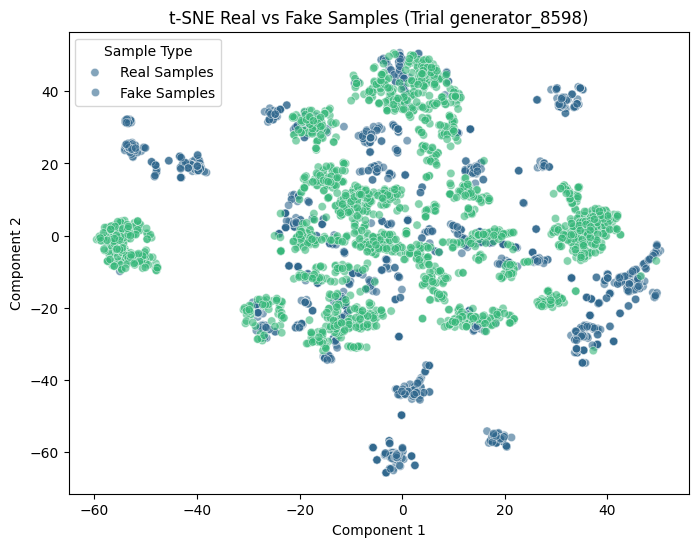

In [43]:
g_loss, d_loss, mcs, quality = objective(params)

In [44]:
def plot_losses(generator_losses, discriminator_losses):
    """
    Plots the generator and discriminator losses over epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label="Generator Loss", linestyle='-', color='b')
    plt.plot(discriminator_losses, label="Discriminator Loss", linestyle='-', color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator vs Discriminator Loss")
    plt.legend()
    plt.grid()
    plt.show()

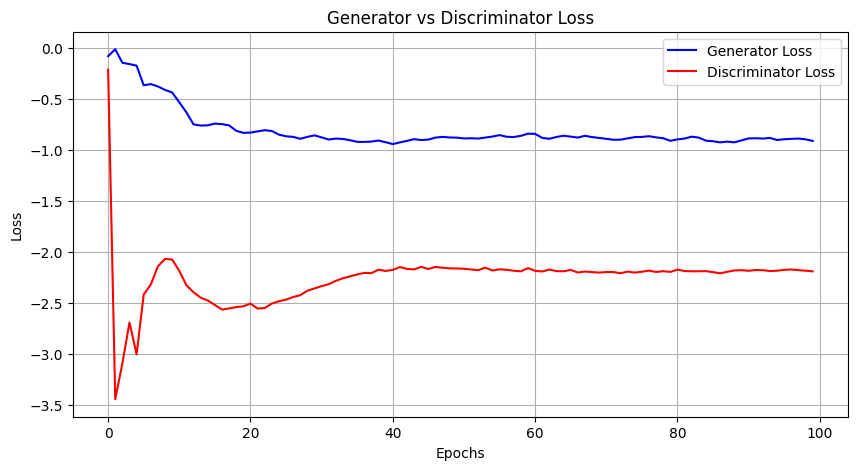

In [45]:
plot_losses(g_loss, d_loss)

In [46]:
def plot_mode_collapse(mode_collapse_scores):
    """
    Plots the mode collapse score using a bar chart.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(mode_collapse_scores)), mode_collapse_scores, color='g', alpha=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Mode Collapse Score")
    plt.title("Mode Collapse Score Over Epochs")
    plt.show()

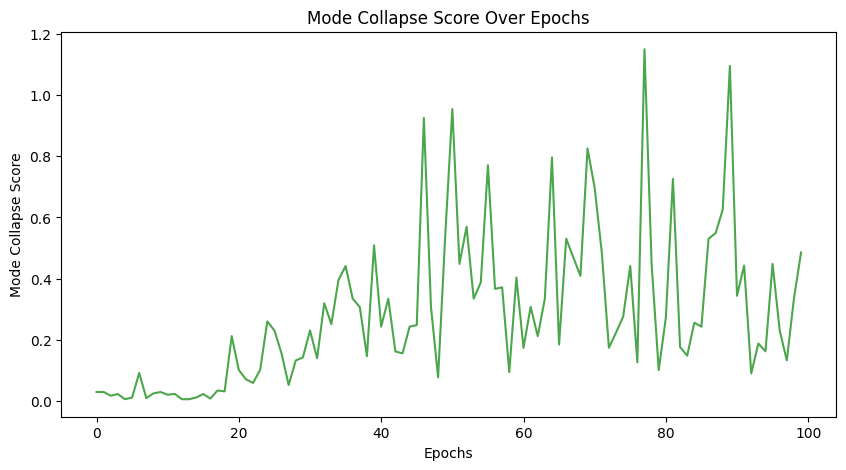

In [47]:
plot_mode_collapse(mcs)

In [51]:
print(f"Quality of the samples is {quality}") 

Quality of the samples is 0.7560481907900365


In [53]:
print(f"Mode Collapse Score is {mcs[-1]}")

Mode Collapse Score is 0.4853587902304574
